<a href="https://colab.research.google.com/github/Droppicode/stock_predictor/blob/main/stock_predictor_last_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import yfinance as yf

dat = yf.Ticker("PETR4.SA")
df = dat.history(period='max')

In [ ]:
del df["Dividends"]
del df["Stock Splits"]
df = df.loc["2000-01-01":].copy()

In [ ]:
df['Change_1'] = df['Close'].pct_change(1)
df['Change_5'] = df['Close'].pct_change(5)
df['Change_20'] = df['Close'].pct_change(20)

df['Volatility_20'] = df['Change_1'].rolling(window=20).std()

df['Vol_Mean'] = df['Volume'].rolling(window=20).mean()
df['Ratio_Volume'] = df['Volume'] / df['Vol_Mean']

# --- Médias Móveis (Tendência) ---

df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_9'] = df['Close'].ewm(span=9, adjust=False).mean()

df['Ratio_SMA_20'] = df['Close'] / df['SMA_20']
df['Ratio_SMA_50'] = df['Close'] / df['SMA_50']
df['Ratio_EMA_9']  = df['Close'] / df['EMA_9']

# --- RSI / IFR (Força) ---

delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

mean_gain = gain.ewm(com=13, adjust=False).mean()
mean_loss = loss.ewm(com=13, adjust=False).mean()

# --- Bandas de Bollinger (Volatilidade) ---

rs = mean_gain / mean_loss
df['RSI_14'] = 100 - (100 / ( 1 + rs))

std_dev = df['Close'].rolling(window=20).std()
bb_upper = df['SMA_20'] + (2 * std_dev)
bb_lower = df['SMA_20'] - (2 * std_dev)

df['Pos_Bollinger'] = (df['Close'] - bb_lower) / (bb_upper - bb_lower)

# --- MACD (Ciclos) ---

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()

macd_line = ema_12 - ema_26
signal_line = macd_line.ewm(span=9, adjust=False).mean()

df['MACD_Hist'] = macd_line - signal_line

df['target'] = (df['Close'].pct_change(periods=5).shift(-5) > 0).astype(int)

df = df.dropna()

In [ ]:
train_size = int(len(df) * 0.8)

train = df.iloc[:-train_size]
test = df.iloc[-train_size:]

features = [
    'Ratio_SMA_20', 'Ratio_EMA_9', 'Pos_Bollinger', 'RSI_14',
    'Change_5', 'Change_20',
    'Volatility_20', 'MACD_Hist'
]

x_train = train[features]
y_train = train['target']

x_test = test[features]
y_test = test['target']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from joblib import Parallel, delayed

def process_window(i, data, features, model_params, step_size):
    # Separa dados
    train = data.iloc[:i]
    test = data.iloc[i : i + step_size]

    if len(test) == 0:
        return None

    # Cria uma NOVA instância do modelo para este processo (leve e rápida)
    # n_jobs=1 aqui porque o paralelismo já está no loop externo
    model = RandomForestClassifier(**model_params, n_jobs=1)

    # Treina e Prevê
    model.fit(train[features], train["target"])
    preds_proba = model.predict_proba(test[features])[:, 1]

    # Retorna o pedacinho do resultado
    return pd.DataFrame({
        "Date": test.index,
        "Real": test["target"],
        "Probabilidade": preds_proba,
        "Close": test["Close"]
    })

def backtest_fast(data, features, start_size=1000, step_size=60, thresh_long=0.55, thresh_short=0.45):
    # Parâmetros do modelo otimizados para velocidade e generalização
    model_params = {
        "n_estimators": 100,
        "max_depth": 5,
        "min_samples_leaf": 10,
        "random_state": 42
    }

    # Cria a lista de índices para as janelas
    indices = range(start_size, len(data), step_size)

    print(f"Iniciando processamento paralelo de {len(indices)} janelas...")

    # n_jobs=-1 usa TODOS os núcleos do seu processador
    results_list = Parallel(n_jobs=-1)(
        delayed(process_window)(i, data, features, model_params, step_size)
        for i in indices
    )

    # Junta todos os pedaços
    df_res = pd.concat([r for r in results_list if r is not None]).set_index("Date")

    df_res["Sinal"] = 0
    df_res.loc[df_res["Probabilidade"] > thresh_long, "Sinal"] = 1
    df_res.loc[df_res["Probabilidade"] < thresh_short, "Sinal"] = -1

    df_res["Retorno_Ativo"] = df_res["Close"].pct_change(10).shift(-10)
    df_res["Retorno_Modelo"] = df_res["Sinal"] * df_res["Retorno_Ativo"]

    return df_res

Iniciando processamento paralelo de 346 janelas...

--- RESULTADOS ---
Trades Totais: 2156 (Long: 2009, Short: 147)
Acurácia nos Trades: 52.46%
Retorno Final Modelo: 454.55%
Retorno Final Buy&Hold: 3285.85%


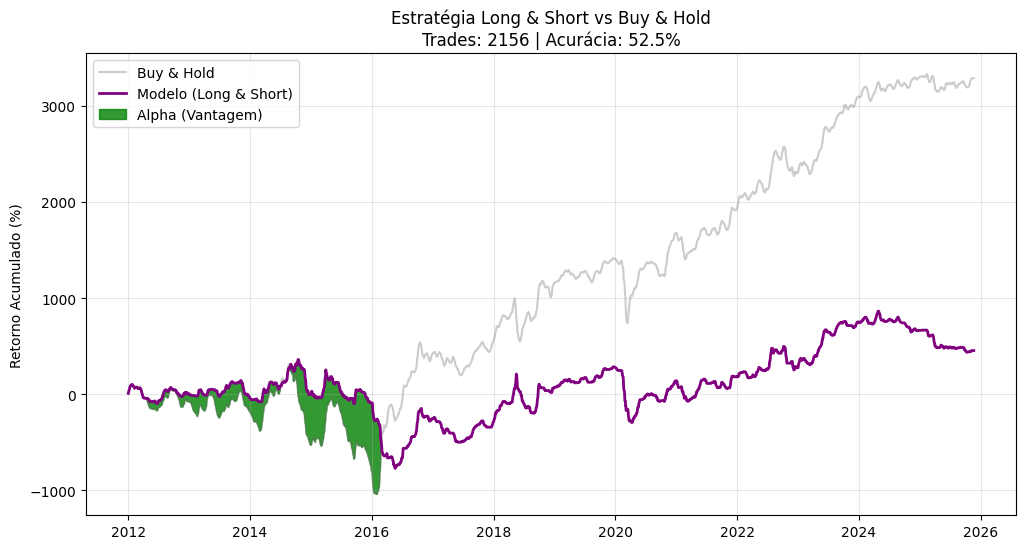

In [ ]:
# Defina seus parâmetros
threshold_compra = 0.53
threshold_venda = 0.43

# Executa o backtest
df_result = backtest_fast(df, features, start_size=3000, step_size=10, thresh_long=threshold_compra, thresh_short=threshold_venda)

# Soma Simples de Retornos (% acumulada)
df_result["Acumulado_BuyHold"] = df_result["Retorno_Ativo"].fillna(0).cumsum() * 100
df_result["Acumulado_Modelo"] = df_result["Retorno_Modelo"].fillna(0).cumsum() * 100

# Contagem de Trades
n_long = (df_result["Sinal"] == 1).sum()
n_short = (df_result["Sinal"] == -1).sum()
total_trades = n_long + n_short

# Acurácia Direcional
operacoes = df_result[df_result["Sinal"] != 0].copy()
operacoes["Real_Dir"] = operacoes["Real"].replace(0, -1)
acuracia = accuracy_score(operacoes["Real_Dir"], operacoes["Sinal"])

print(f"\n--- RESULTADOS ---")
print(f"Trades Totais: {total_trades} (Long: {n_long}, Short: {n_short})")
print(f"Acurácia nos Trades: {acuracia*100:.2f}%")
print(f"Retorno Final Modelo: {df_result['Acumulado_Modelo'].iloc[-1]:.2f}%")
print(f"Retorno Final Buy&Hold: {df_result['Acumulado_BuyHold'].iloc[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_result.index, df_result["Acumulado_BuyHold"], label="Buy & Hold", color="gray", alpha=0.4)
plt.plot(df_result.index, df_result["Acumulado_Modelo"], label="Modelo (Long & Short)", color="purple", linewidth=2)

plt.fill_between(df_result.index, df_result["Acumulado_Modelo"], df_result["Acumulado_BuyHold"],
                 where=(df_result["Acumulado_Modelo"] > df_result["Acumulado_BuyHold"]),
                 color="green", alpha=0.8, label="Alpha (Vantagem)")

plt.title(f"Estratégia Long & Short vs Buy & Hold\nTrades: {total_trades} | Acurácia: {acuracia*100:.1f}%")
plt.ylabel("Retorno Acumulado (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

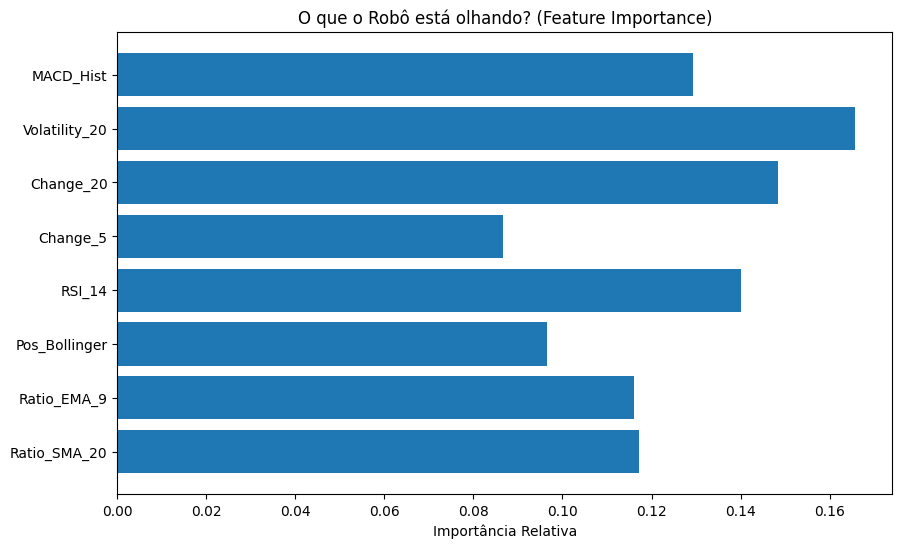

Distribuição do Alvo no Treino:
target
1    0.549961
0    0.450039
Name: proportion, dtype: float64


In [ ]:
importances = model.feature_importances_
indices = range(len(importances))
names = [x_train.columns[i] for i in indices]

# Plota
plt.figure(figsize=(10, 6))
plt.title("O que o Robô está olhando? (Feature Importance)")
plt.barh(indices, importances, align='center')
plt.yticks(indices, names)
plt.xlabel('Importância Relativa')
plt.show()

# Checa o desequilíbrio do Alvo
print("Distribuição do Alvo no Treino:")
print(y_train.value_counts(normalize=True))